# 'ledyba' Package for Girl-Ladyboy Detection
Mental notes for creating the `ledyba` package

In [1]:
#image stuff
import cv2
from PIL import Image

#the usual data science stuff
import numpy as np

#keras
from keras.models import Model
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout, Activation, BatchNormalization

data_path = '/home/charin.polpanumas/ladybug/data/'
weight_path = data_path+'processed/weight/'
temp_path = data_path+'temp/'

Using TensorFlow backend.


In [2]:
cascade_file_src = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascade_file_src)

# Detect Face

In [3]:
def detect_face(imagePath): 
    # load image on gray scale :
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the image :
    faces = faceCascade.detectMultiScale(gray, 1.2, 5)

    #skip if face not detected
    if(len(faces)==0):
        return('No Face')

    #open image
    im = Image.open(imagePath)

    #get box dimensions
    (x, y, w, h) = faces[0]
    center_x = x+w/2
    center_y = y+h/2
    b_dim = min(max(w,h)*1.2,im.width, im.height)
    box = (int(center_x-b_dim/2), int(center_y-b_dim/2), 
           int(center_x+b_dim/2), int(center_y+b_dim/2))
    # Crop Image
    crpim = im.crop(box).resize((224,224))
    return(crpim)

# Initialize Custom Model

In [4]:
def vgg_face():
    img = Input(shape=(224, 224,3))

    #convolution layers
    conv1_1 = Conv2D(64, (3,3), activation='relu', name='conv1_1',padding='same')(img)
    conv1_2 = Conv2D(64, (3,3), activation='relu', name='conv1_2',padding='same')(conv1_1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool1')(conv1_2)

    conv2_1 = Conv2D(128, (3,3), activation='relu', name='conv2_1',padding='same')(pool1)
    conv2_2 = Conv2D(128, (3,3), activation='relu', name='conv2_2',padding='same')(conv2_1)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool2')(conv2_2)

    conv3_1 = Conv2D(256, (3,3), activation='relu', name='conv3_1',padding='same')(pool2)
    conv3_2 = Conv2D(256, (3,3), activation='relu', name='conv3_2',padding='same')(conv3_1)
    conv3_3 = Conv2D(256, (3,3), activation='relu', name='conv3_3',padding='same')(conv3_2)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool3')(conv3_3)

    conv4_1 = Conv2D(512, (3,3), activation='relu', name='conv4_1',padding='same')(pool3)
    conv4_2 = Conv2D(512, (3,3), activation='relu', name='conv4_2',padding='same')(conv4_1)
    conv4_3 = Conv2D(512, (3,3), activation='relu', name='conv4_3',padding='same')(conv4_2)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool4')(conv4_3)

    conv5_1 = Conv2D(512, (3,3), activation='relu', name='conv5_1',padding='same')(pool4)
    conv5_2 = Conv2D(512, (3,3), activation='relu', name='conv5_2',padding='same')(conv5_1)
    conv5_3 = Conv2D(512, (3,3), activation='relu', name='conv5_3',padding='same')(conv5_2)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool5')(conv5_3)

    #classification layer of original mat file
    fc6 = Conv2D(4096, (7,7), activation='relu', name='fc6',padding='valid')(pool5)
    fc6_drop = Dropout(0.5)(fc6)
    fc7 = Conv2D(4096, (1,1), activation='relu', name='fc7',padding='valid')(fc6_drop)
    fc7_drop = Dropout(0.5)(fc7)
    fc8 = Conv2D(2622, (1,1), activation='relu', name='fc8',padding='valid')(fc7_drop)
    flat = Flatten(name='flat')(fc8)
    prob = Activation('softmax',name='prob')(flat)

    model = Model(inputs=img, outputs=prob)

    return model

def init_model(weight_location,nb_class,fc_dim,do_p):
    #empty model
    model = vgg_face()

    #finetuning
    last_layer = model.get_layer('pool5').output

    x = Flatten(name='flatten')(last_layer)
    x = Dense(fc_dim, activation='relu', name='fc6')(x)
    x = BatchNormalization(name='fc6_bn')(x)
    x = Dropout(do_p)(x)
    x = Dense(fc_dim,activation='relu', name='fc7')(x)
    x = BatchNormalization(name='fc7_bn')(x)
    x = Dropout(do_p)(x)
    out = Dense(nb_class, activation='softmax', name='fc8')(x)
    custom_model = Model(model.input, out)

    #load weights
    custom_model.load_weights(weight_location)
    return(custom_model)

In [5]:
custom_model = init_model(weight_path+'custom_model.h5',2,512,0.5)
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

# Predict

In [6]:
def predict_gender(im,model,label_name=['girl','ladyboy']):
    #convert to array
    arr = np.array(im).astype(np.float32)
    #add extra dimension
    arr = np.expand_dims(arr, axis=0)
    #mean center
    #arr[:,:,0] -= 129.1863
    #arr[:,:,1] -= 104.7624
    #arr[:,:,2] -= 93.5940
    #predict
    out = model.predict(arr)
    #get index
    best_index = np.argmax(out, axis=1)[0]
    best_name = label_name[best_index]
    return(best_index, best_name, out[0,best_index])

(1, 'ladyboy', 0.89021397)


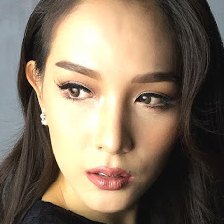

In [7]:
image_file = 'tiff2016.jpg'
crpim = detect_face(temp_path+image_file)
print(predict_gender(crpim,custom_model))
crpim

(0, 'girl', 0.92305273)


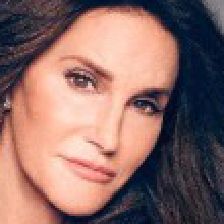

In [8]:
image_file = 'caitlyn_girl.jpg'
import ledyba
crpim = detect_face(temp_path+image_file)
print(ledyba.predict_gender(crpim))
crpim